# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [ ]:
# do  wizualizacji
#  https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
Display().start()
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

!pip install gym --upgrade
import numpy as np
import gym
import random
import time

In [2]:
# auxiliary function for tests
def get_state_info_taxi(state: np.ndarray):
    state_info = state[0]
    destination = state_info%4
    state_info = (state_info - destination)//4
    passenger_location = state_info%5
    state_info = (state_info - passenger_location)//5
    taxi_col = state_info%5
    state_info = (state_info - taxi_col)//5
    taxi_row = state_info
    return f"Destination: {destination}, Passenger_location: {passenger_location}, Taxi_row: {taxi_row}, Taxi_col: {taxi_col}"


class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
        env = None
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        self.q_table = np.zeros([self.observation_space, self.action_space])  # Q-Table initiation
        self.rendered_images = []
        self.is_game_solved = False
        if 'render_mode' in self.env.spec.kwargs:
            self.render_mode = True
        else: self.render_mode = False
        self.q_table_plot_info = {}

    def build_q_table(self, episodes: int, steps_number: int):
        penalties_per_episode = []
        timesteps_per_episode = []
        rewards_per_episode = []
        for _ in range(episodes):
            state = self.env.reset()[0]
            penalties = 0
            rewards = 0
            for steps in range(steps_number):
                if random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    if not any(self.q_table[state]):  # when Q-table empty for current state to better exploration
                        action = self.env.action_space.sample()
                    else:
                        action = np.argmax(self.q_table[state])

                new_state, reward, terminated, truncated, info = self.env.step(action)
                if reward < 0:
                    penalties += 1
                if reward > 0:
                    rewards += 1
                q_for_current_state = self.q_table[state][action]
                q_for_next_state = self.q_table[new_state][np.argmax(self.q_table[new_state])]
                reward =  q_for_current_state + self.learning_rate * (reward + self.gamma * q_for_next_state- q_for_current_state)
                self.update(state, action, reward)
                state = new_state
                if terminated or truncated:
                    break

            rewards_per_episode.append(rewards)
            penalties_per_episode.append(penalties)
            timesteps_per_episode.append(steps)

        self.q_table_plot_info['episodes'] = episodes
        self.q_table_plot_info['timesteps_per_episode'] = timesteps_per_episode
        self.q_table_plot_info['penalties_per_episode'] = penalties_per_episode
        self.q_table_plot_info['rewards_per_episode'] = rewards_per_episode


    def plot_q_table_info(self):
        episodes = self.q_table_plot_info['episodes']
        timesteps_per_episode = self.q_table_plot_info['timesteps_per_episode']
        penalties_per_episode = self.q_table_plot_info['penalties_per_episode']
        rewards_per_episode = self.q_table_plot_info['rewards_per_episode']

        fig, ax = plt.subplots(figsize = (20, 4))
        ax.set_title("Timesteps to complete level")
        ax.plot(range(episodes), timesteps_per_episode)
        plt.show()

        fig, ax = plt.subplots(figsize = (20, 4))
        ax.set_title("Number of penalties per episode")
        line1, = ax.plot(range(episodes), penalties_per_episode)
        line2, = ax.plot(range(episodes), rewards_per_episode)
        line1.set_label('Penalties')
        line2.set_label('Rewards')
        ax.legend()
        plt.show()

    def test(self, state: np.ndarray, limit:int = 25):
        if self.render_mode:
            self.rendered_images.append(self.env.render())

        action = self.get_best_action(state[0])
        new_state, reward, terminated, truncated, info = self.env.step(action)
        if self.render_mode:
            self.rendered_images.append(self.env.render())

        while not terminated:
            if truncated or limit < 0:
                return False
            limit-=1
            action = self.get_best_action(new_state)
            new_state, reward, terminated, truncated, info = self.env.step(action)
            if self.render_mode:
                self.rendered_images.append(self.env.render())

        # now works only for discrete games such as 'CliffWalking-v0', 'Taxi-v3' and 'FrozenLake-v1' ('4x4', '8x8')
        self.is_game_solved = True
        if (self.env.spec.id == 'CliffWalking-v0' and new_state != 36):
            pass
        elif (self.env.spec.id == 'Taxi-v3' and state[0]%4 == ((new_state- new_state%4)//4)%5):
            pass
        elif (self.env.spec.id == 'FrozenLake-v1') and (self.env.observation_space.n-1) == new_state:
            pass
        else:
            self.is_game_solved = False
        return self.is_game_solved

    def print_q_table(self):
        print(self.q_table)

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_table[state][action]

    def update(self, state: np.ndarray, action: np.ndarray, reward: float) -> None:
        """Update Q-value of given state and action."""
        self.q_table[state][action] = reward

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        if not any(self.q_table[state]): # if no best action then random
            return self.env.action_space.sample()
        return np.argmax(self.q_table[state])

    def animation(self):
        img = plt.imshow(self.rendered_images[0])
        for render in self.rendered_images:
            img.set_data(render)
            display.display(plt.gcf())
            display.clear_output(wait=True)
            time.sleep(0.4)

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        if not self.render_mode:
            return "Turn on render mode to see animation or use function print_q_table to see Q-table"
        self.animation()
        if self.is_game_solved:
            return "Game solved correctly!"
        else:
            return "Game hasn't been solved!"

    def __str__(self):
        if not self.render_mode:
            return "Turn on render mode to see animation or use function print_q_table to see Q-table"
        return self.__repr__()

In [3]:
env = gym.make('Taxi-v3')
qls = QLearningSolver(env.observation_space.n, env.action_space.n, env=env)
qls.build_q_table(2500, 100)
qls.print_q_table()
env.close()

[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.45739889 -2.62659799 -3.46064026 -2.89543093  1.61367333 -6.6262821 ]
 [-0.41600689 -1.08353752 -2.00822644  1.53059472  7.71466268 -5.76388125]
 ...
 [-1.04661746  0.45550244 -1.04519056 -1.02718306 -2.81194648 -1.        ]
 [-2.05723212 -2.07445029 -2.05983993 -2.10030185 -4.54225359 -5.14797658]
 [-0.199      -0.31094119 -0.199      10.94339609 -1.         -1.        ]]


# Eksperymenty

In [4]:
def test_qls(env_name, animation:bool, number_of_episodes, steps_in_episode, print_plot_test, map_name="4x4", is_slippery=False, limit=False):
    if env_name=="FrozenLake-v1":
        if animation:
            test_env = gym.make(id=env_name, render_mode='rgb_array', map_name=map_name, is_slippery=is_slippery)
        else:
            test_env = gym.make(id=env_name, map_name=map_name,is_slippery=is_slippery)
    else:
        if animation:
            test_env = gym.make(id=env_name, render_mode='rgb_array')
        else:
            test_env = gym.make(id=env_name)
    qls_test = QLearningSolver(test_env.observation_space.n, test_env.action_space.n, env=test_env)
    qls_test.build_q_table(number_of_episodes, steps_in_episode)
    if not limit:
        game_solved = qls_test.test(test_env.reset(), limit=100)
    else:
        game_solved = qls_test.test(test_env.reset())
    if animation:
        print(qls_test)
    if print_plot_test:
        qls_test.plot_q_table_info()
        print("Game solved: ", game_solved)
    test_env.close()
    return game_solved
def get_qls_accuracy(env_name, num_episode_list, num_steps_in_episode_list, map_name="4x4", is_slippery=False, limit=True, gamma=0.9, epsilon=0.1, learning_rate=0.1):
    number_of_tests = 100

    if env_name == "FrozenLake-v1":
        test_env = gym.make(id=env_name, map_name=map_name, is_slippery=is_slippery)
    else:
        test_env = gym.make(id=env_name)

    fig, axs = plt.subplots(len(num_steps_in_episode_list), figsize=(10, 15), sharex=True)  # Use plt.subplots() for 1D array of Axes

    for i, step in enumerate(num_steps_in_episode_list):
        accuracies = []  # accuracies per steps number

        for episod in num_episode_list:
            qls_test = QLearningSolver(test_env.observation_space.n, test_env.action_space.n, env=test_env, gamma=gamma, epsilon=epsilon, learning_rate=learning_rate)
            qls_test.build_q_table(episod,step)
            successes = 0

            for _ in range(number_of_tests):
                game_solved = qls_test.test(test_env.reset())
                if game_solved:
                    successes += 1

            accuracy = successes / number_of_tests
            accuracies.append(accuracy)

        axs[i].plot(num_episode_list, accuracies)
        axs[i].set_title(f'Accuracy in terms of episodes for {step} steps')
        axs[i].set_xticks(num_episode_list)
        axs[i].set_xticklabels( num_episode_list)

    axs[-1].set_xlabel(f'Plot for {test_env.spec.id} per episodes')
    plt.tight_layout()
    plt.show()




def get_qls_accuracy_hiperparameter(env_name, episode_list, hiperparameter, hiperparameter_list, map_name="4x4", is_slippery=False, limit=True):
    number_of_tests = 100

    if env_name == "FrozenLake-v1":
        test_env = gym.make(id=env_name, map_name=map_name, is_slippery=is_slippery)
    else:
        test_env = gym.make(id=env_name)

    fig, axs = plt.subplots(len(episode_list), figsize=(10, 10), sharex=True)  # Use plt.subplots() for 1D array of Axes

    for i, episod in enumerate(episode_list):
        accuracies = []  # accuracies per steps number

        for hparam in hiperparameter_list:
            if hiperparameter == "learning_rate":
                qls_test = QLearningSolver(test_env.observation_space.n, test_env.action_space.n, env=test_env, learning_rate=hparam)

            elif hiperparameter == "epsilon":
                qls_test = QLearningSolver(test_env.observation_space.n, test_env.action_space.n, env=test_env, epsilon=hparam)
            else:
                qls_test = QLearningSolver(test_env.observation_space.n, test_env.action_space.n, env=test_env, gamma=hparam)

            qls_test.build_q_table(episod,100)
            successes = 0

            for _ in range(number_of_tests):
                game_solved = qls_test.test(test_env.reset())
                if game_solved:
                    successes += 1

            accuracy = successes / number_of_tests
            accuracies.append(accuracy)

        axs[i].plot(hiperparameter_list, accuracies)
        axs[i].set_title(f'Accuracy in terms of {hiperparameter}')
        axs[i].set_xticks(hiperparameter_list)
        axs[i].set_xticklabels(hiperparameter_list)

    axs[-1].set_xlabel(f'Plot for {test_env.spec.id}, {hiperparameter}')
    plt.tight_layout()
    plt.show()


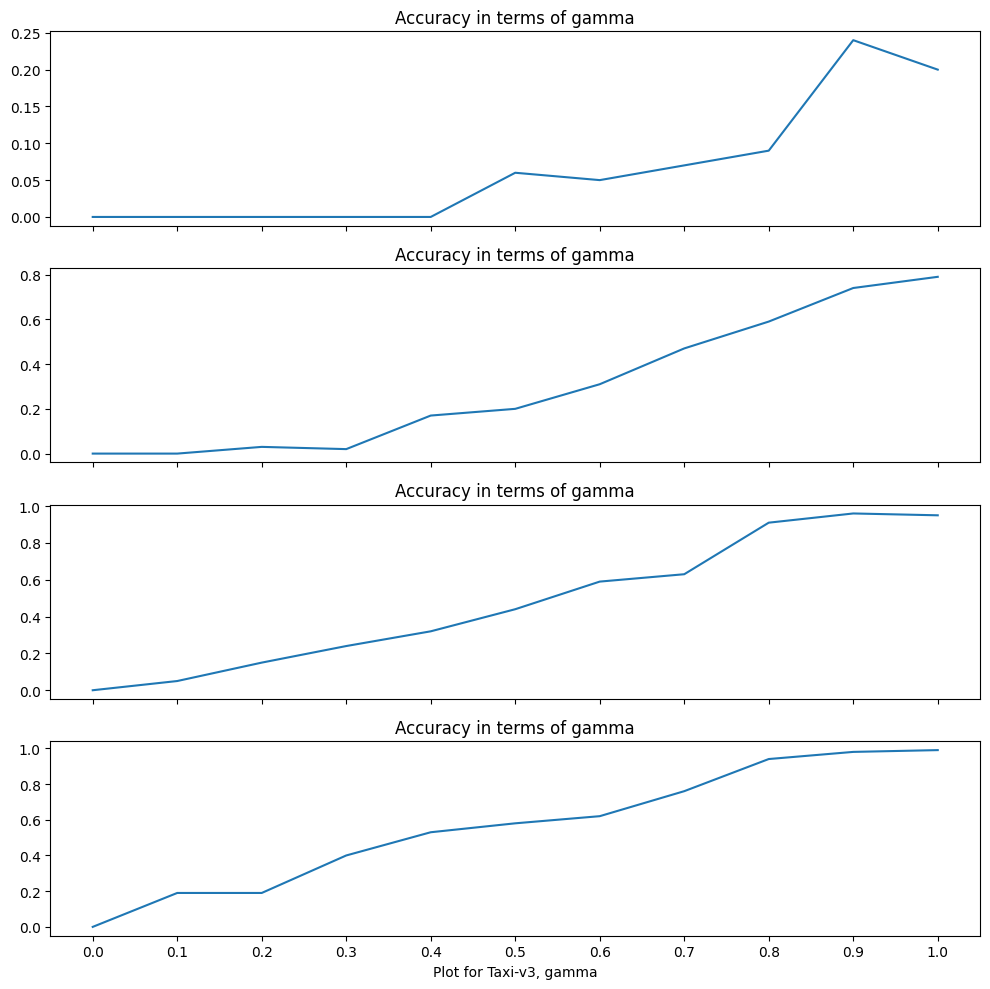

In [5]:
get_qls_accuracy_hiperparameter("Taxi-v3", [1000,2000,3000, 4000],'gamma', [i/10 for i in range(11)])

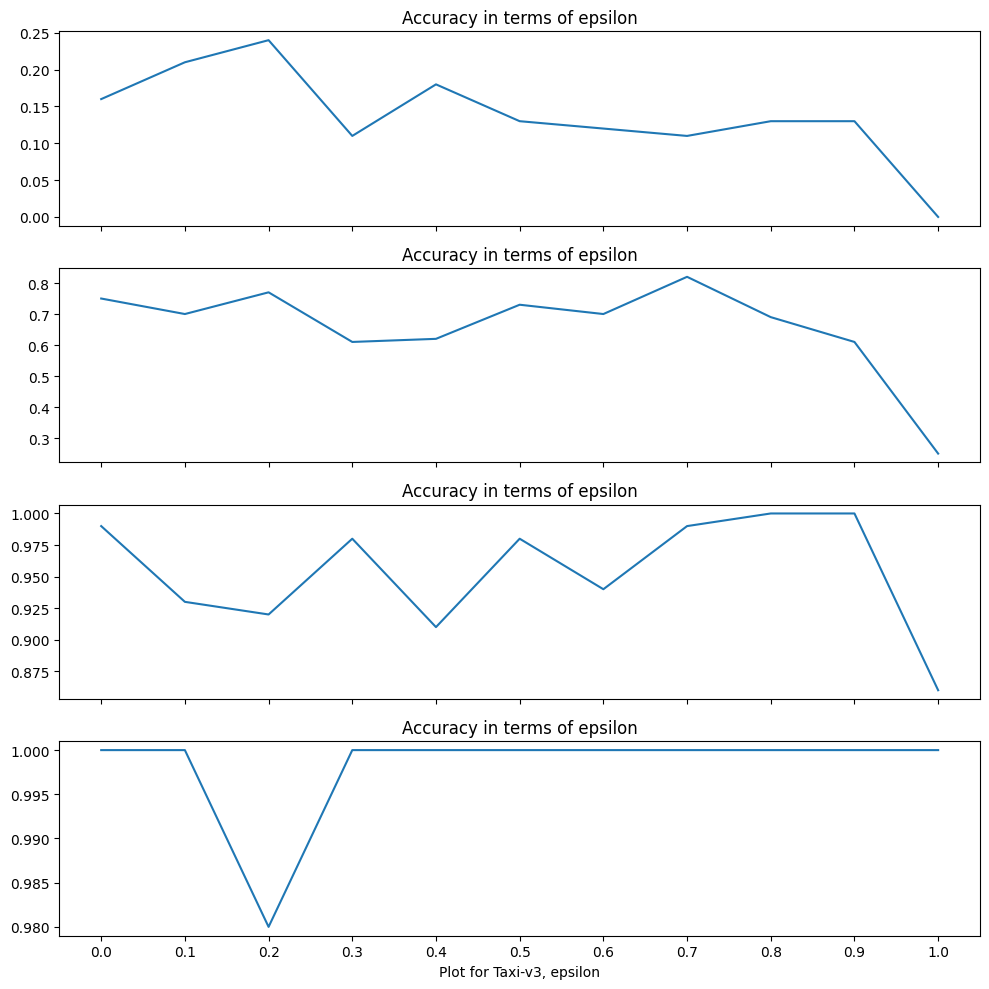

In [6]:
get_qls_accuracy_hiperparameter("Taxi-v3", [1000,2000,3000,4000],'epsilon', [i/10 for i in range(11)])

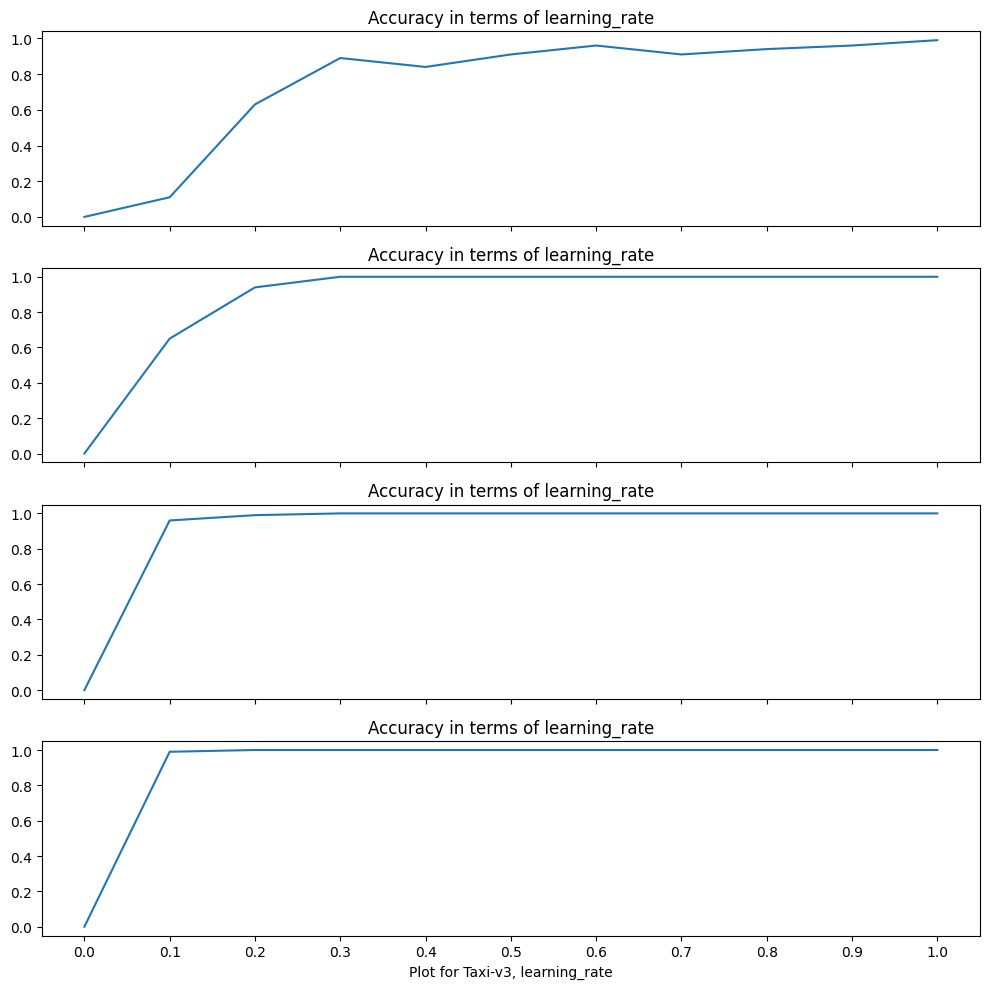

In [7]:
get_qls_accuracy_hiperparameter("Taxi-v3", [1000,2000,3000,4000],'learning_rate', [i/10 for i in range(11)])

Game solved correctly!


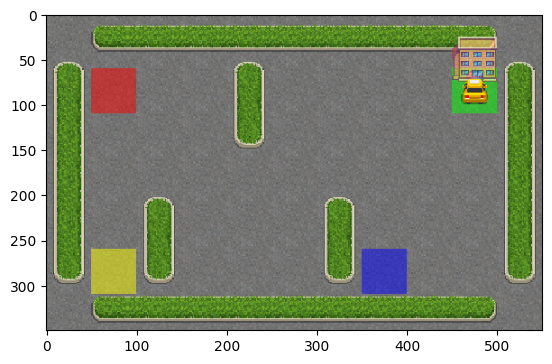

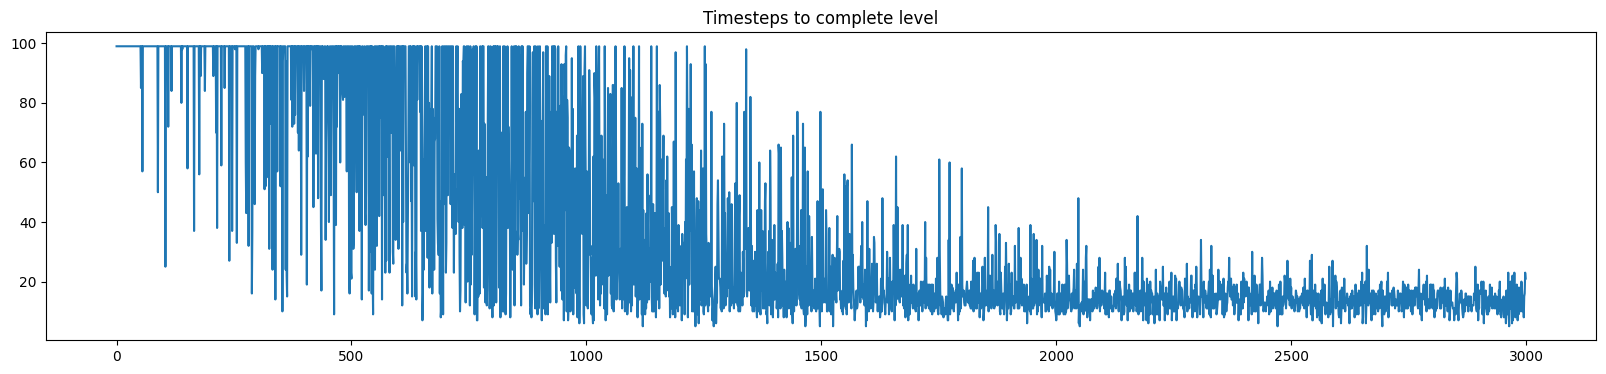

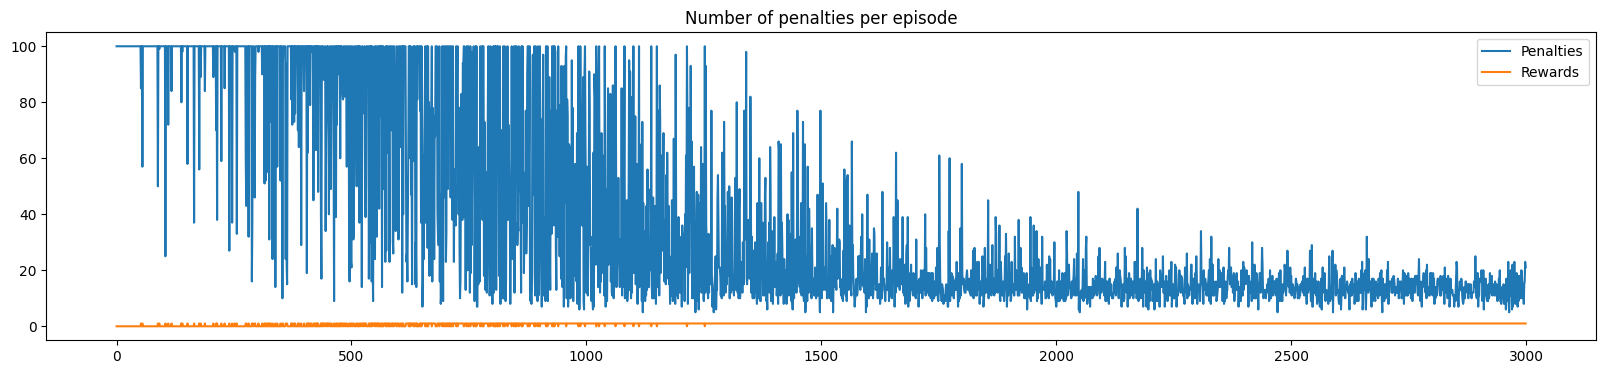

Game solved:  True


True

In [8]:
test_qls(env_name="Taxi-v3", animation=True, number_of_episodes=3000, steps_in_episode=100, print_plot_test=True)

Game solved correctly!


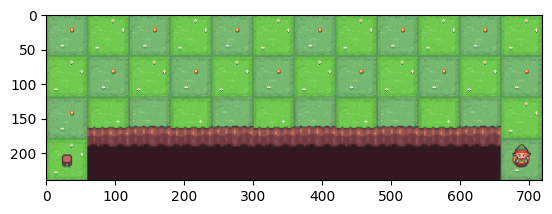

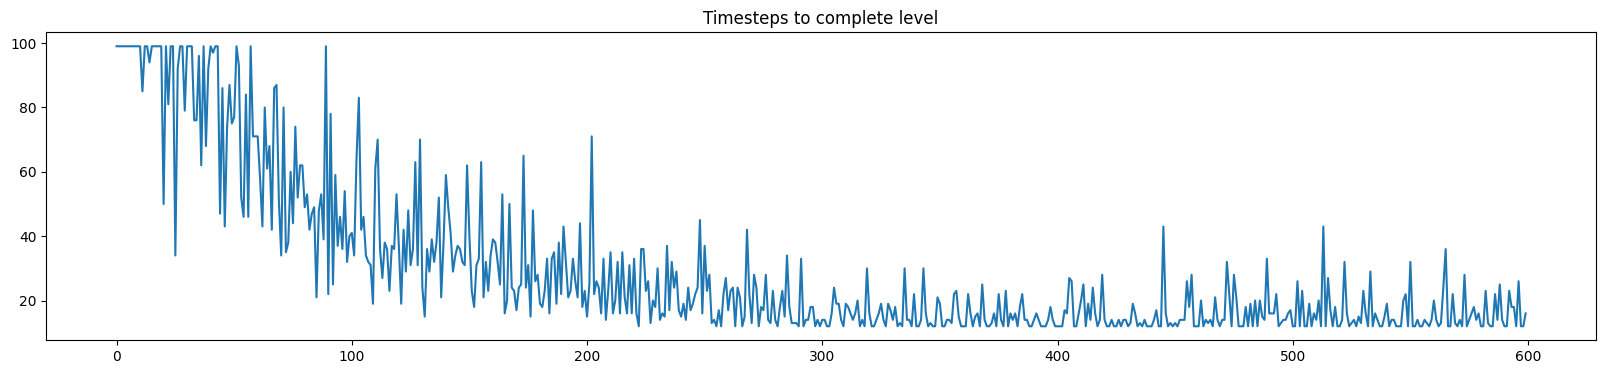

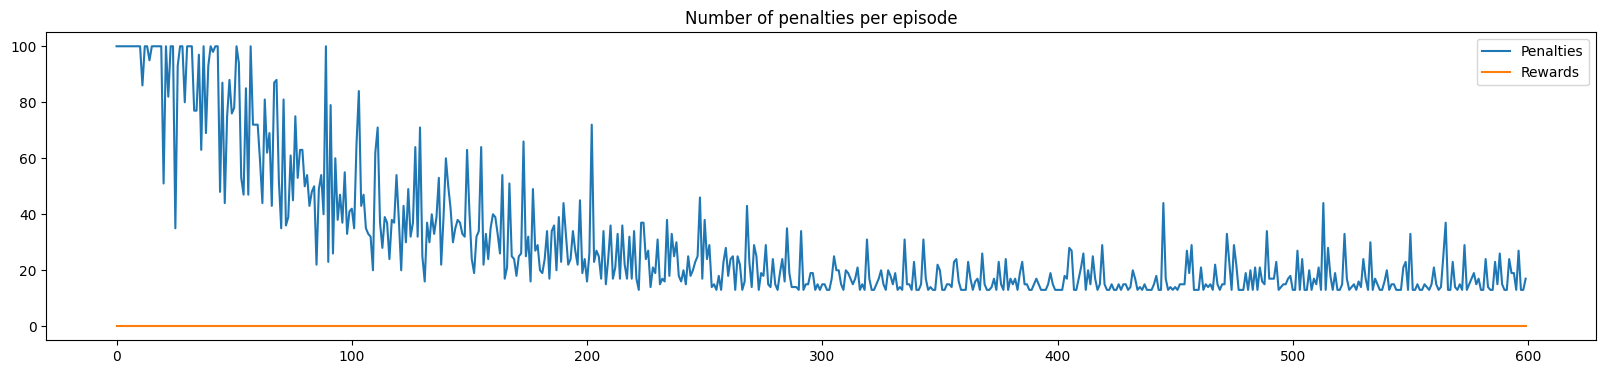

Game solved:  True


True

In [32]:
test_qls(env_name="CliffWalking-v0", animation=True, number_of_episodes=600, steps_in_episode=100, print_plot_test=True)

Game solved correctly!


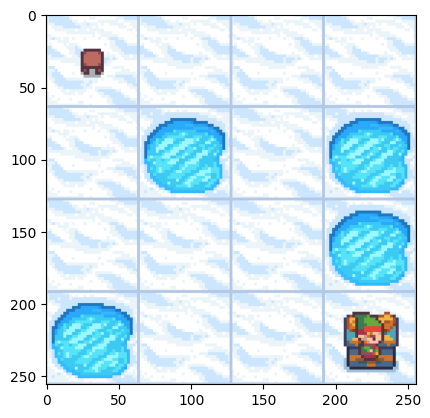

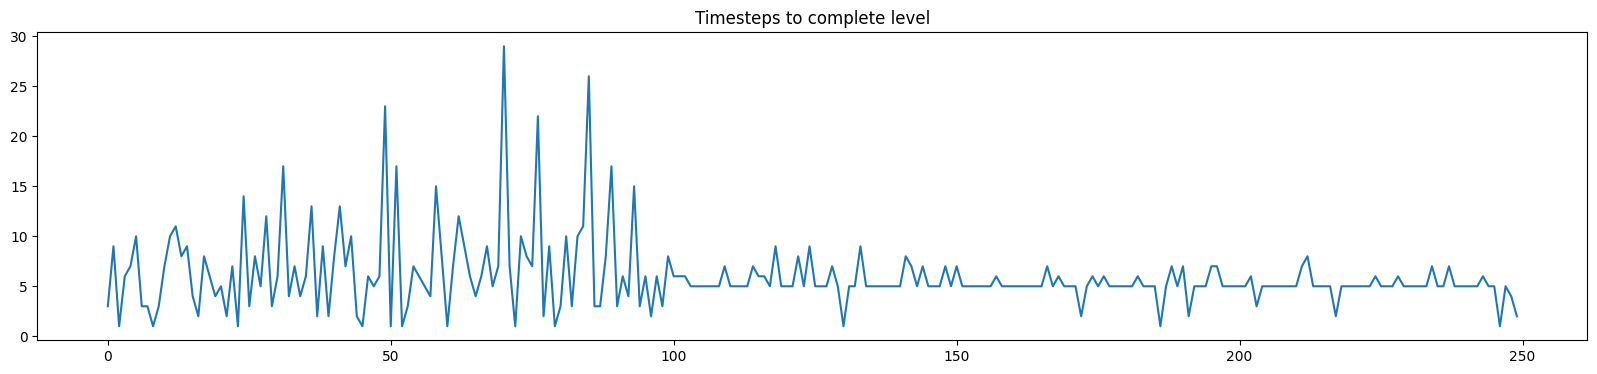

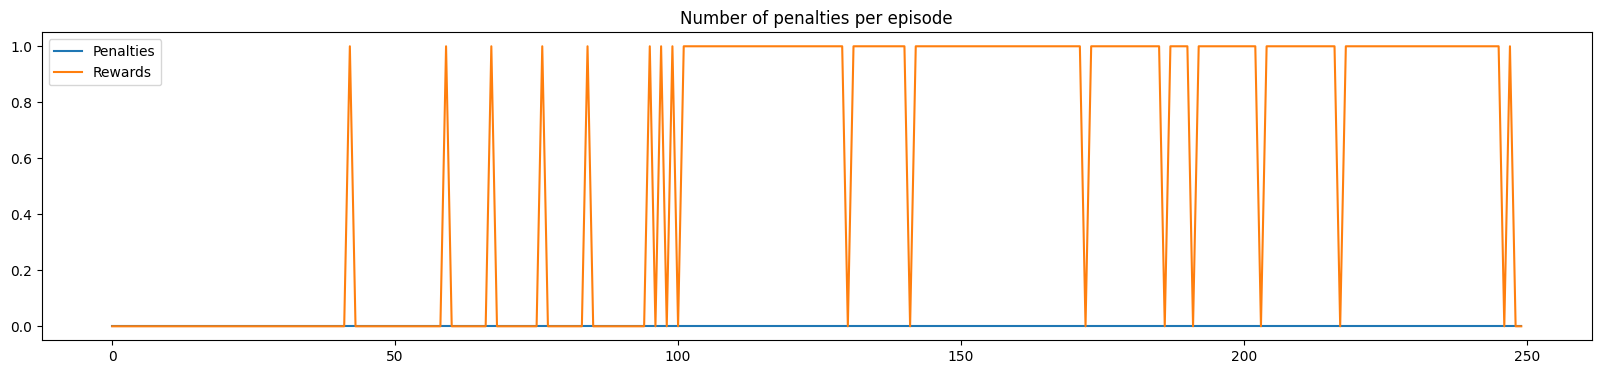

Game solved:  True


True

In [33]:
test_qls(env_name="FrozenLake-v1", animation=True, number_of_episodes=250, steps_in_episode=100, print_plot_test=True)

In [2]:
test_qls(env_name="FrozenLake-v1", animation=True, number_of_episodes=1500, steps_in_episode=100, print_plot_test=True, map_name="8x8")

NameError: ignored

In [15]:
episode_list = [50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
steps_in_episode_list = [50,100,150,200]

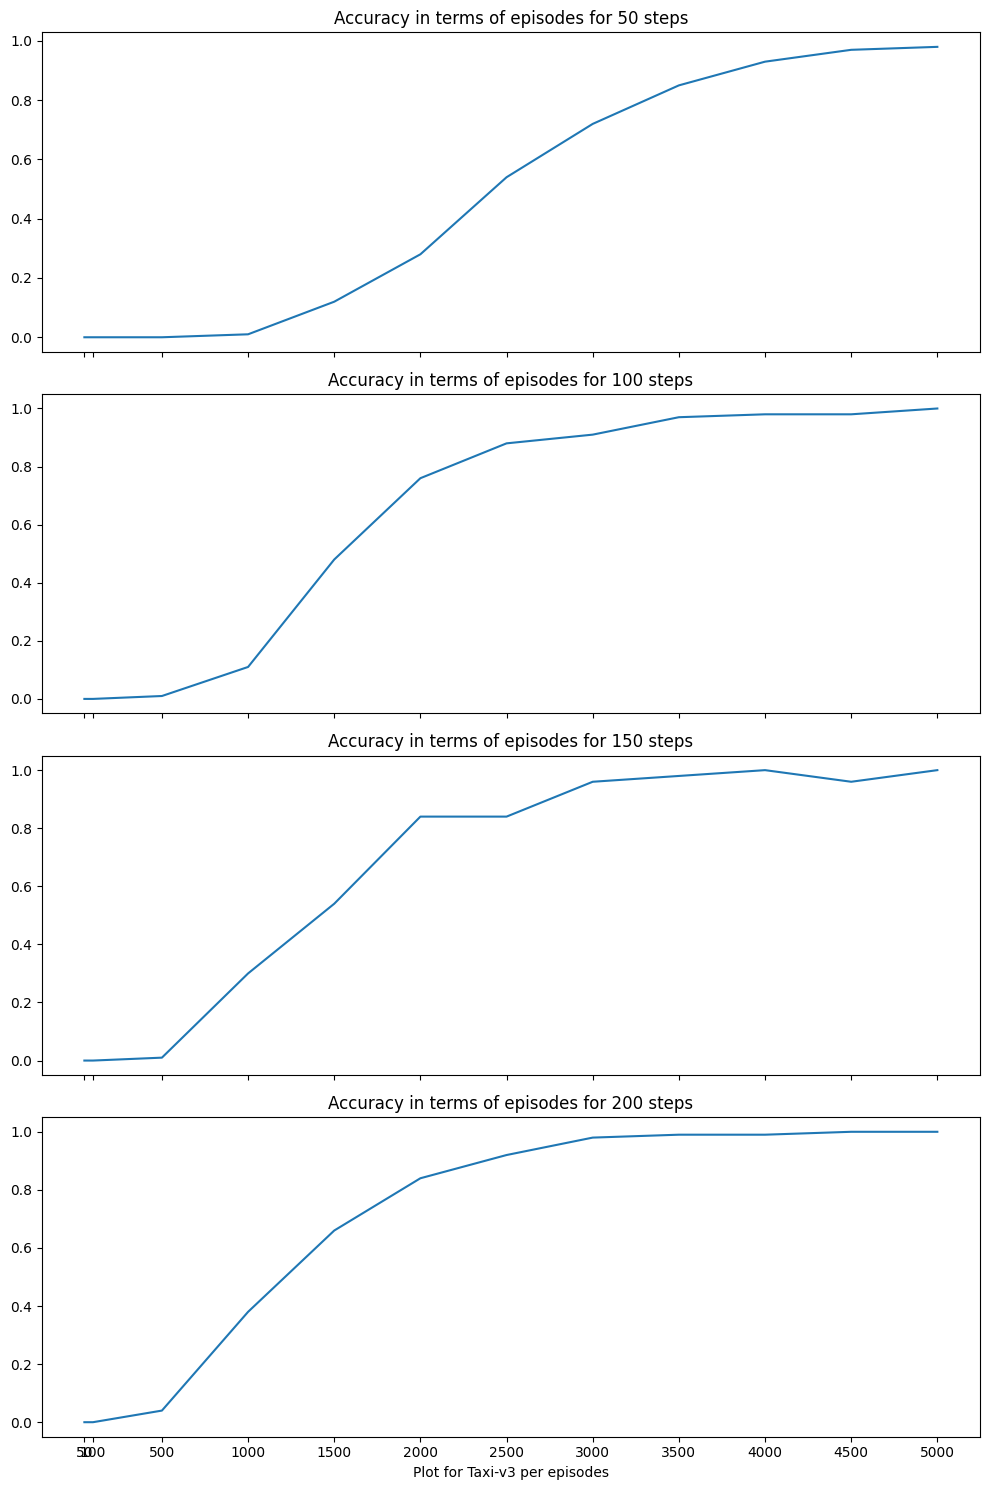

In [16]:
get_qls_accuracy("Taxi-v3", episode_list, steps_in_episode_list)

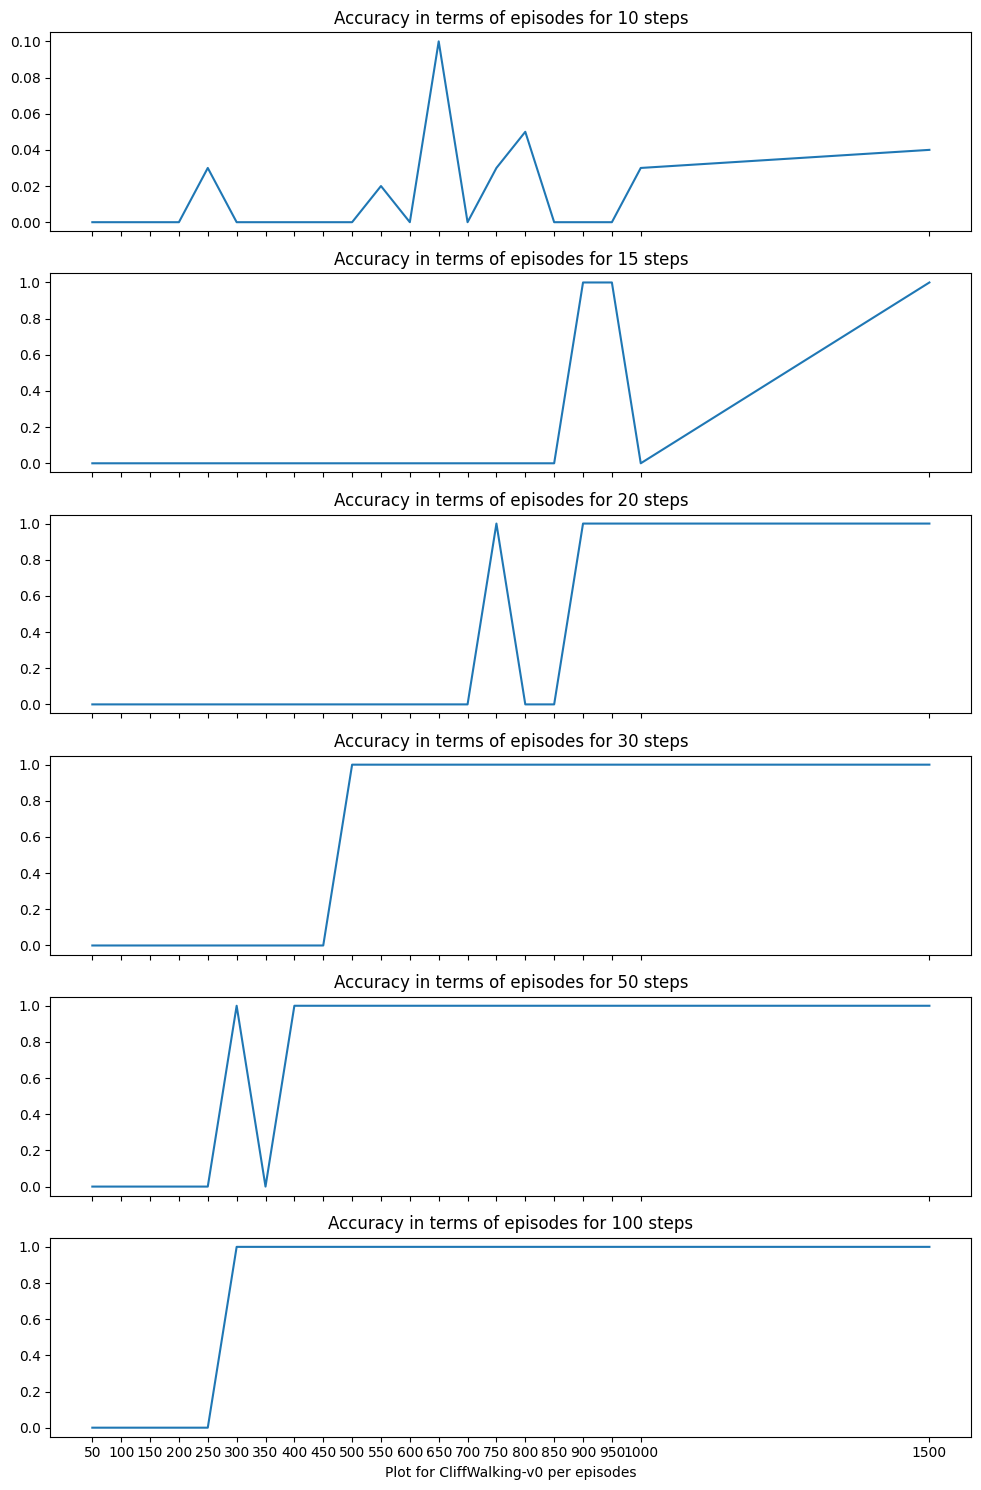

In [29]:
episode_list = [50*a for a in range(1,21)]+[1500]
steps_in_episode_list = [10, 15, 20, 30, 50,100]
get_qls_accuracy("CliffWalking-v0", episode_list, steps_in_episode_list)

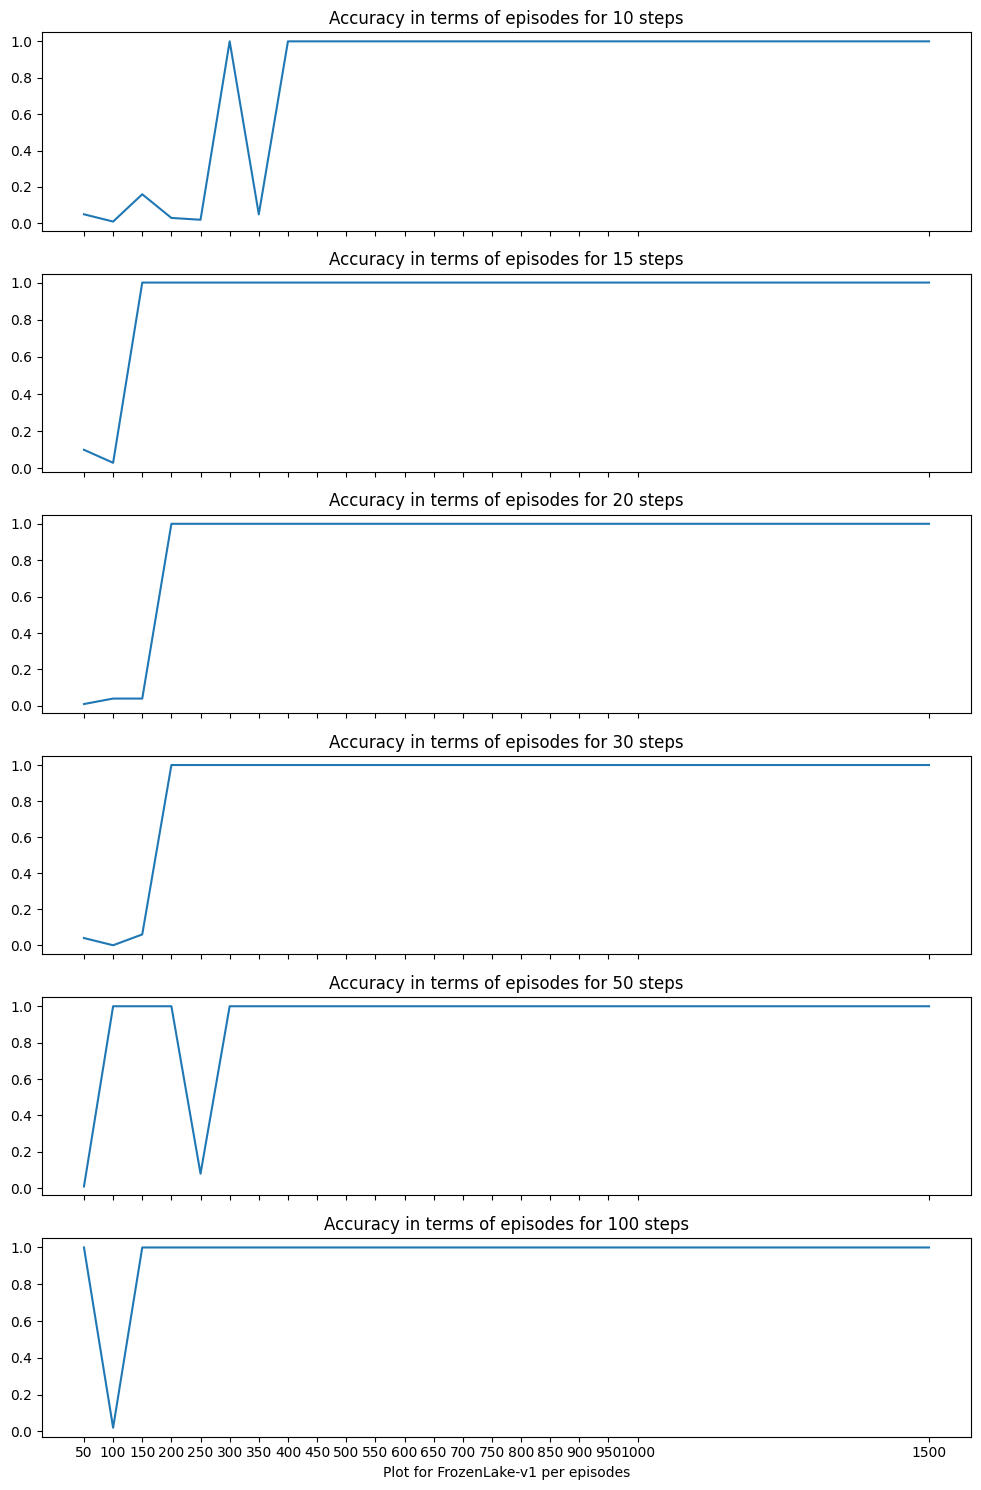

In [30]:
get_qls_accuracy("FrozenLake-v1", episode_list, steps_in_episode_list)

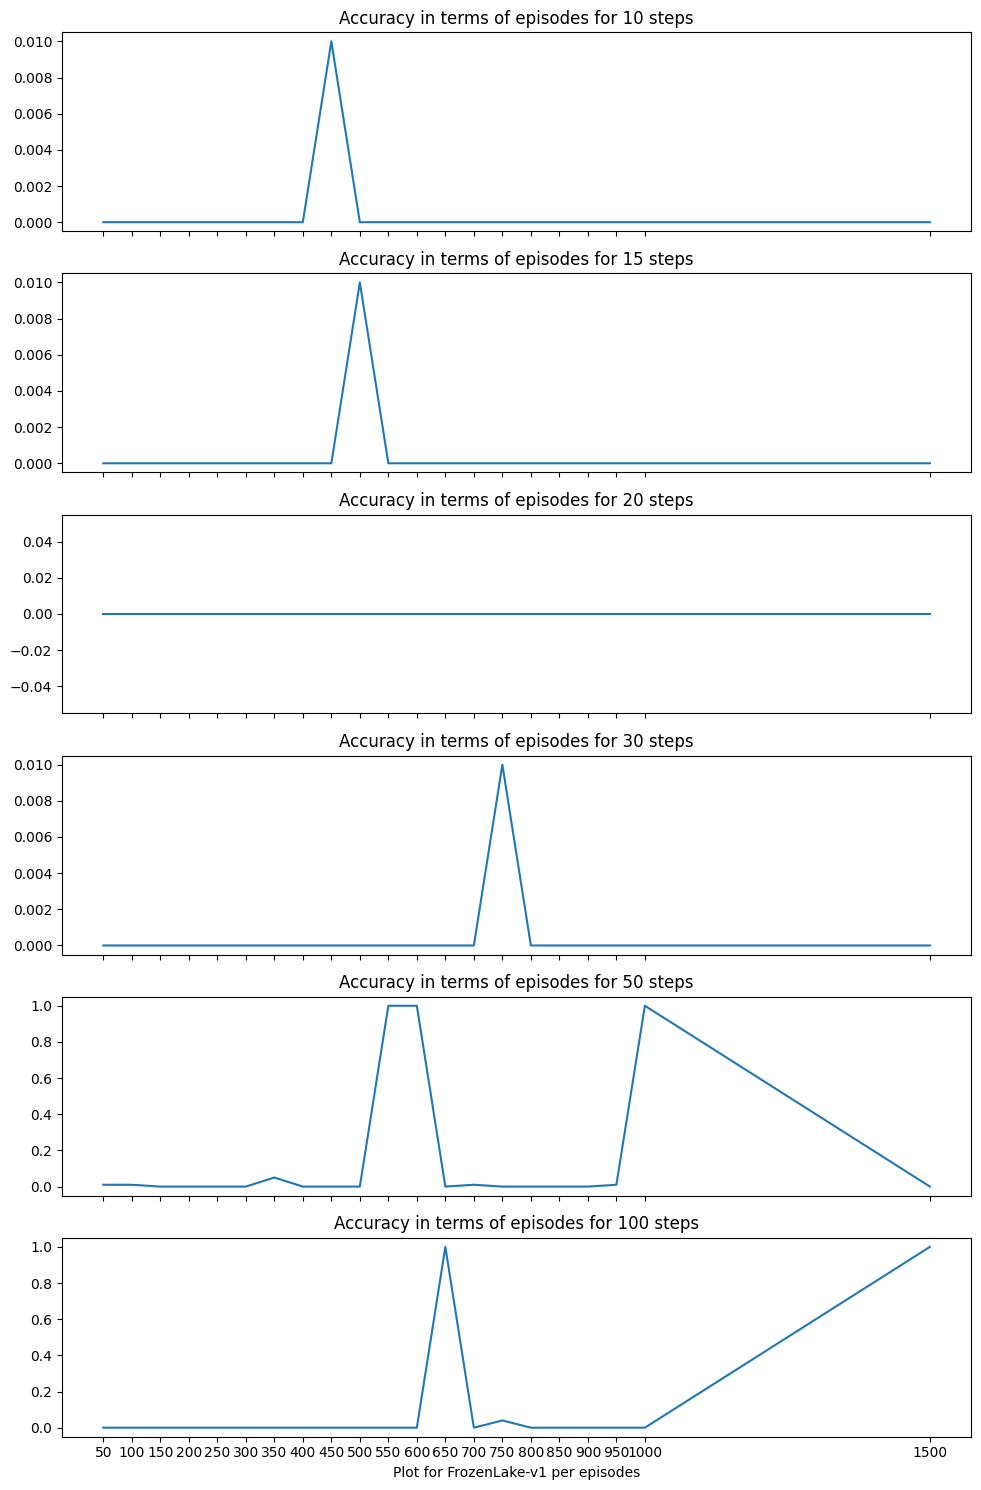

In [31]:
get_qls_accuracy("FrozenLake-v1", episode_list, steps_in_episode_list, map_name="8x8")

# Wnioski

Zaimplementowany algorytm Q-learningu działa poprawnie. W zależności od złożoności środowiska potrzebujemy różnej liczby  epizodów oraz ruchów na epizod.
